# Importing Libraries Needed

In [3]:
import gdown
import zipfile
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, load_img, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

Mount Drive if needed

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Preparing Datasets

In [ ]:
file_url = "https://docs.google.com/uc?id=1D7978btbkjMQOyIUMo9l7gqGms6-WFOP"
output_file = "/tmp/Brev_AgroAid_Datasets.zip"

gdown.download(file_url, output=output_file)

Downloading...
From: https://docs.google.com/uc?id=1D7978btbkjMQOyIUMo9l7gqGms6-WFOP
To: /tmp/Brev_AgroAid_Datasets.zip
100%|██████████| 212M/212M [00:03<00:00, 69.6MB/s]


'/tmp/Brev_AgroAid_Datasets.zip'

In [ ]:
with zipfile.ZipFile('/tmp/Brev_AgroAid_Datasets.zip', 'r') as f:
    f.extractall('/tmp')

In [ ]:
BASE_DIR = "/tmp/Brev_AgroAid_Datasets"
CHERRY_TRAIN_DIR = BASE_DIR + "/train/Cherry"
CHERRY_VAL_DIR = BASE_DIR + "/valid/Cherry"
PEACH_TRAIN_DIR = BASE_DIR + "/train/Peach"
PEACH_VAL_DIR = BASE_DIR + "/valid/Peach"
STRAWBERRY_TRAIN_DIR = BASE_DIR + "/train/Strawberry"
STRAWBERRY_VAL_DIR = BASE_DIR + "/valid/Strawberry"

# Build Helper Function

Data Generator Function

In [ ]:
def build_image_datagen(train_dir, val_dir):
  training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=256
  )

  validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=256
  )

  print(train_generator.class_indices.keys())

  return train_generator, validation_generator

Select some layers from ResNet

In [ ]:
def select_layers_pre_trained_model(end_layer):
  pre_trained_model = ResNet50V2(input_shape=(224, 224, 3),
                                   include_top=False,
                                   weights='imagenet')

  for layer in pre_trained_model.layers:
      layer.trainable = False

  last_layer = pre_trained_model.layers[end_layer]
  last_output = last_layer.output

  return pre_trained_model, last_output

Build and compile the model

In [ ]:
def build_and_compile_model(pre_trained_model, last_output):
  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense  (2, activation='softmax')(x)

  model = tf.keras.Model(pre_trained_model.input, x)


  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

Train model

In [ ]:
def train_model(model, epochs, train_generator, validation_generator):
  history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = epochs)
  return history

Plot the performance of the model

In [ ]:
def plot_model_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.show()

# Working with Cherry Dataset

Perform data augmentation and build the data generator

In [ ]:
cherry_train_generator, cherry_validation_generator = build_image_datagen(CHERRY_TRAIN_DIR, CHERRY_VAL_DIR)

Found 3509 images belonging to 2 classes.
Found 877 images belonging to 2 classes.
dict_keys(['Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy'])


Build the architecture and train the model

In [ ]:
pre_trained_model, last_output = select_layers_pre_trained_model(38)
cherry_model = build_and_compile_model(pre_trained_model, last_output)
cherry_history = train_model(cherry_model,
                             epochs=30,
                             train_generator=cherry_train_generator,
                             validation_generator=cherry_validation_generator)

94668760/94668760 [==============================] - 5s 0us/step
Epoch 1/30
14/14 [==============================] - 62s 4s/step - loss: 34.4099 - accuracy: 0.5668 - val_loss: 0.4315 - val_accuracy: 0.9225
Epoch 2/30
14/14 [==============================] - 49s 4s/step - loss: 1.9844 - accuracy: 0.8712 - val_loss: 0.4462 - val_accuracy: 0.9521
Epoch 3/30
14/14 [==============================] - 49s 4s/step - loss: 0.3572 - accuracy: 0.9535 - val_loss: 0.2554 - val_accuracy: 0.9624
Epoch 4/30
14/14 [==============================] - 50s 3s/step - loss: 0.1385 - accuracy: 0.9712 - val_loss: 0.0982 - val_accuracy: 0.9704
Epoch 5/30
14/14 [==============================] - 48s 4s/step - loss: 0.0714 - accuracy: 0.9775 - val_loss: 0.0326 - val_accuracy: 0.9875
Epoch 6/30
14/14 [==============================] - 50s 4s/step - loss: 0.0544 - accuracy: 0.9795 - val_loss: 0.0752 - val_accuracy: 0.9749
Epoch 7/30
14/14 [==============================] - 48s 3s/step - loss: 0.0505 - accuracy: 0.9

Plot the accuracy of the model for each epoch

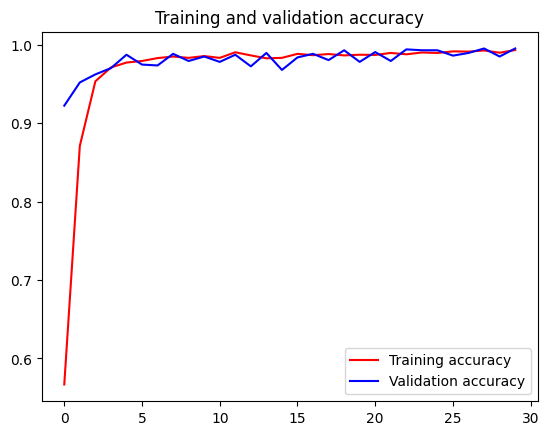

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_model_performance(cherry_history)

Save the model

In [ ]:
# tf.saved_model.save(cherry_model, "/tmp/saved_model/cherry")
cherry_model.save("/tmp/saved_model/cherry/cherry_model.h5")

# Working with Peach Dataset

Perform data augmentation and build the data generator

In [ ]:
peach_train_generator, peach_validation_generator = build_image_datagen(PEACH_TRAIN_DIR, PEACH_VAL_DIR)

Found 3566 images belonging to 2 classes.
Found 891 images belonging to 2 classes.
dict_keys(['Peach___Bacterial_spot', 'Peach___healthy'])


Build the architecture and train the model

In [ ]:
pre_trained_model, last_output = select_layers_pre_trained_model(38)
peach_model = build_and_compile_model(pre_trained_model, last_output)
peach_history = train_model(peach_model,
                            epochs=30,
                            train_generator=peach_train_generator,
                            validation_generator=peach_validation_generator)

Epoch 1/30
14/14 [==============================] - 55s 4s/step - loss: 48.4284 - accuracy: 0.6141 - val_loss: 1.1694 - val_accuracy: 0.9214
Epoch 2/30
14/14 [==============================] - 51s 4s/step - loss: 3.8201 - accuracy: 0.8968 - val_loss: 0.6693 - val_accuracy: 0.9675
Epoch 3/30
14/14 [==============================] - 49s 3s/step - loss: 1.2879 - accuracy: 0.9492 - val_loss: 0.2907 - val_accuracy: 0.9798
Epoch 4/30
14/14 [==============================] - 52s 4s/step - loss: 0.5160 - accuracy: 0.9661 - val_loss: 0.0470 - val_accuracy: 0.9944
Epoch 5/30
14/14 [==============================] - 49s 4s/step - loss: 0.3084 - accuracy: 0.9711 - val_loss: 0.0506 - val_accuracy: 0.9899
Epoch 6/30
14/14 [==============================] - 49s 3s/step - loss: 0.2576 - accuracy: 0.9683 - val_loss: 0.0256 - val_accuracy: 0.9921
Epoch 7/30
14/14 [==============================] - 49s 4s/step - loss: 0.1725 - accuracy: 0.9683 - val_loss: 0.0337 - val_accuracy: 0.9910
Epoch 8/30
14/14 [=

Plot the accuracy of the model for each epoch

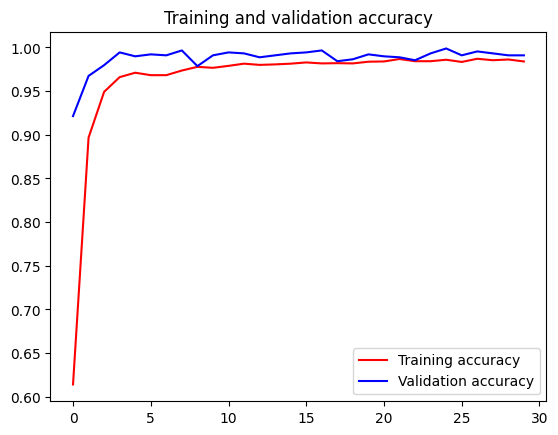

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_model_performance(peach_history)

Save the model

In [ ]:
# tf.saved_model.save(peach_model, "/tmp/saved_model/peach")
peach_model.save("/tmp/saved_model/peach/peach_model.h5")

# Working with Strawberry Dataset

Perform data augmentation and build the data generator

In [ ]:
strawberry_train_generator, strawberry_validation_generator = build_image_datagen(STRAWBERRY_TRAIN_DIR, STRAWBERRY_VAL_DIR)

Found 3598 images belonging to 2 classes.
Found 900 images belonging to 2 classes.
dict_keys(['Strawberry___Leaf_scorch', 'Strawberry___healthy'])


Build the architecture and train the model

In [ ]:
pre_trained_model, last_output = select_layers_pre_trained_model(38)
strawberry_model = build_and_compile_model(pre_trained_model, last_output)
strawberry_history = train_model(strawberry_model,
                                 epochs=30,
                                 train_generator=strawberry_train_generator,
                                 validation_generator=strawberry_validation_generator)

Epoch 1/30
15/15 [==============================] - 56s 4s/step - loss: 24.5698 - accuracy: 0.7248 - val_loss: 0.3071 - val_accuracy: 0.9833
Epoch 2/30
15/15 [==============================] - 51s 3s/step - loss: 1.2548 - accuracy: 0.9516 - val_loss: 0.0865 - val_accuracy: 0.9900
Epoch 3/30
15/15 [==============================] - 49s 3s/step - loss: 0.4510 - accuracy: 0.9728 - val_loss: 0.0552 - val_accuracy: 0.9922
Epoch 4/30
15/15 [==============================] - 50s 3s/step - loss: 0.2160 - accuracy: 0.9767 - val_loss: 0.0158 - val_accuracy: 0.9956
Epoch 5/30
15/15 [==============================] - 49s 3s/step - loss: 0.1320 - accuracy: 0.9800 - val_loss: 0.0306 - val_accuracy: 0.9956
Epoch 6/30
15/15 [==============================] - 51s 3s/step - loss: 0.0738 - accuracy: 0.9833 - val_loss: 0.0680 - val_accuracy: 0.9922
Epoch 7/30
15/15 [==============================] - 51s 4s/step - loss: 0.0844 - accuracy: 0.9842 - val_loss: 0.0262 - val_accuracy: 0.9944
Epoch 8/30
15/15 [=

Plot the accuracy of the model for each epoch

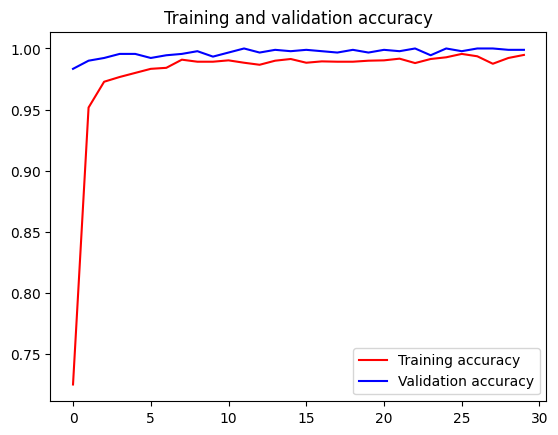

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_model_performance(strawberry_history)

Save the model

In [ ]:
# tf.saved_model.save(strawberry_model, "/tmp/saved_model/strawberry")
strawberry_model.save("/tmp/saved_model/strawberry/strawberry_model.h5")

# Model Inference

Load Data Test Set v2

> These test datasets are gathered from internet and some of it not really represent the distribution of train and validation data.

In [ ]:
file_url = "https://docs.google.com/uc?id=1f7c_Xj19udQpXSeQI1KAukrMEA_LrKo6"
output_file = "/tmp/test_data_v2.zip"

gdown.download(file_url, output=output_file)

Downloading...
From: https://docs.google.com/uc?id=1f7c_Xj19udQpXSeQI1KAukrMEA_LrKo6
To: /tmp/test_data_v2.zip
100%|██████████| 1.76M/1.76M [00:00<00:00, 102MB/s]


'/tmp/test_data_v2.zip'

In [ ]:
with zipfile.ZipFile('/tmp/test_data_v2.zip', 'r') as f:
    f.extractall('/tmp')

In [ ]:
BASE_DIR = '/tmp/test_data'
CHERRY_TEST_DIR = BASE_DIR + '/cherry'
PEACH_TEST_DIR = BASE_DIR + '/peach'
STRAWBERRY_TEST_DIR = BASE_DIR + '/strawberry'

Copy saved model from my drive to Colab

In [4]:
import shutil

source_file_path = '/content/drive/MyDrive/Capstone/saved_model_h5.zip'
destination_file_path = '/tmp/saved_model_h5.zip'

shutil.copyfile(source_file_path, destination_file_path)


'/tmp/saved_model_h5.zip'

Unzip model and load it

In [5]:
with zipfile.ZipFile('/tmp/saved_model_h5.zip', 'r') as f:
    f.extractall('/tmp')

In [6]:
cherry_model = tf.keras.models.load_model('/tmp/tmp/saved_model/cherry/cherry_model.h5')
peach_model = tf.keras.models.load_model('/tmp/tmp/saved_model/peach/peach_model.h5')
strawberry_model = tf.keras.models.load_model('/tmp/tmp/saved_model/strawberry/strawberry_model.h5')

Function for Test the Model

In [ ]:
def test_model(plant):

  cherry_labels = ['powdery_mildew', 'healthy'] # ['Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy']
  peach_labels = ['bacterial_spot', 'healthy'] # ['Peach___Bacterial_spot', 'Peach___healthy']
  strawberry_labels = ['leaf_scorch', 'healthy'] # ['Strawberry___Leaf_scorch', 'Strawberry___healthy']

  labels_dict = {'cherry':cherry_labels, 'peach':peach_labels, 'strawberry':strawberry_labels}
  model_dict = {'cherry':cherry_model, 'peach':peach_model, 'strawberry':strawberry_model}
  dir_dict = {'cherry':CHERRY_TEST_DIR, 'peach':PEACH_TEST_DIR, 'strawberry':STRAWBERRY_TEST_DIR}

  labels = labels_dict.get(plant)
  model = model_dict.get(plant)
  dir = dir_dict.get(plant)
  images = os.listdir(dir)

  print("Loaded Images:")
  print(images)
  print('\n')

  # predicting images
  for i in images:
      path = dir + '/' + i
      loaded_image = load_img(path, target_size=(224, 224))
      transformed_image = img_to_array(loaded_image)
      transformed_image = transformed_image / 255.0
      transformed_image = np.expand_dims(transformed_image, axis=0)
      transformed_image = np.vstack([transformed_image])

      prediction_array = model.predict(transformed_image, batch_size=10)
      prediction = labels[np.argmax(prediction_array)]

      print('Image name: %s' % (i))
      print(prediction_array)
      print('This %s is %s' % (plant, prediction))
      print('\n')

Testing on Cherry Model

In [ ]:
test_model('cherry')

Loaded Images:
['healthy_cherry_1.jpg', 'powderymildew_cherry_1.jpg', 'healthy_cherry_2.jpg', 'powderymildew_cherry_2.jpg']


1/1 [==============================] - 8s 8s/step
Image name: healthy_cherry_1.jpg
[[0.99716955 0.0028305 ]]
This cherry is powdery_mildew


1/1 [==============================] - 0s 30ms/step
Image name: powderymildew_cherry_1.jpg
[[1.0000000e+00 7.8642853e-16]]
This cherry is powdery_mildew


1/1 [==============================] - 0s 29ms/step
Image name: healthy_cherry_2.jpg
[[0.31870815 0.6812919 ]]
This cherry is healthy


1/1 [==============================] - 0s 31ms/step
Image name: powderymildew_cherry_2.jpg
[[1.0000000e+00 1.3267743e-12]]
This cherry is powdery_mildew




> The cherry model make one error when predicting a healthy cherry

Testing on Peach Model

In [ ]:
test_model('peach')

Loaded Images:
['bacterialspot_peach_1.jpg', 'healthy_peach_2.jpg', 'healthy_peach_1.jpg', 'bacterialspot_peach_2.jpg']


1/1 [==============================] - 0s 213ms/step
Image name: bacterialspot_peach_1.jpg
[[1. 0.]]
This peach is bacterial_spot


1/1 [==============================] - 0s 20ms/step
Image name: healthy_peach_2.jpg
[[3.3394237e-13 1.0000000e+00]]
This peach is healthy


1/1 [==============================] - 0s 21ms/step
Image name: healthy_peach_1.jpg
[[0.9989359  0.00106417]]
This peach is bacterial_spot


1/1 [==============================] - 0s 23ms/step
Image name: bacterialspot_peach_2.jpg
[[1. 0.]]
This peach is bacterial_spot




> The peach model make one error when predicting a healthy peach

Testing on Strawberry Model

In [ ]:
test_model('strawberry')

Loaded Images:
['healthy_strawberry_1.jpg', 'scorch_strawberry_2.jpg', 'scorch_strawberry_1.jpg', 'healthy_strawberry_2.jpg']


1/1 [==============================] - 0s 195ms/step
Image name: healthy_strawberry_1.jpg
[[7.1504264e-06 9.9999285e-01]]
This strawberry is healthy


1/1 [==============================] - 0s 20ms/step
Image name: scorch_strawberry_2.jpg
[[1. 0.]]
This strawberry is leaf_scorch


1/1 [==============================] - 0s 20ms/step
Image name: scorch_strawberry_1.jpg
[[1. 0.]]
This strawberry is leaf_scorch


1/1 [==============================] - 0s 21ms/step
Image name: healthy_strawberry_2.jpg
[[0.00149339 0.9985066 ]]
This strawberry is healthy




> The strawberry model make no error in this case

# Plot & Export Model Architecture

Cherry model architecture

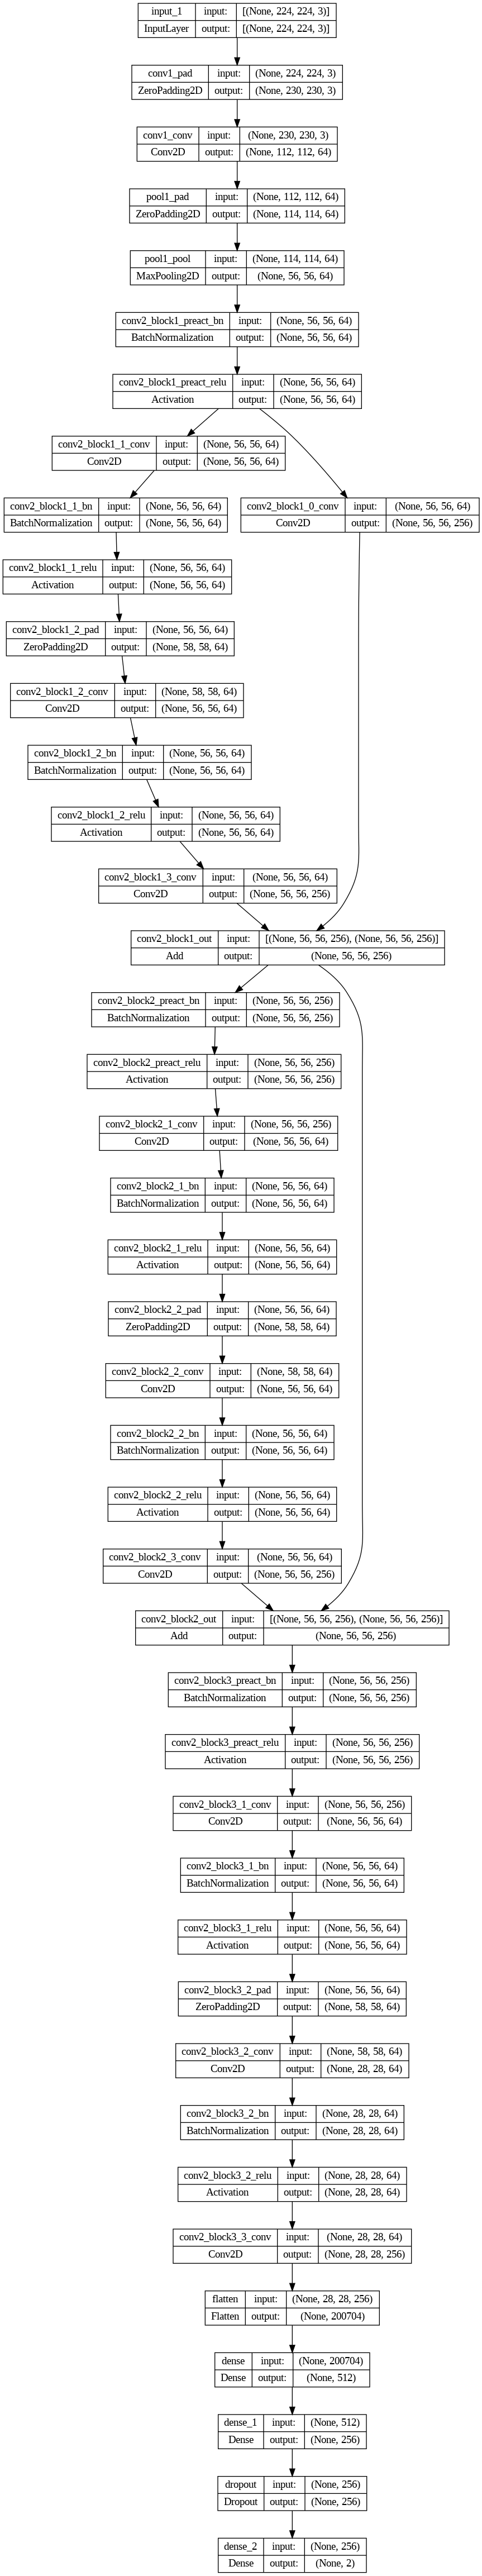

In [7]:
plot_model(cherry_model, show_shapes=True, show_layer_names=True, to_file='cherry_model.png')

Peach model architecture

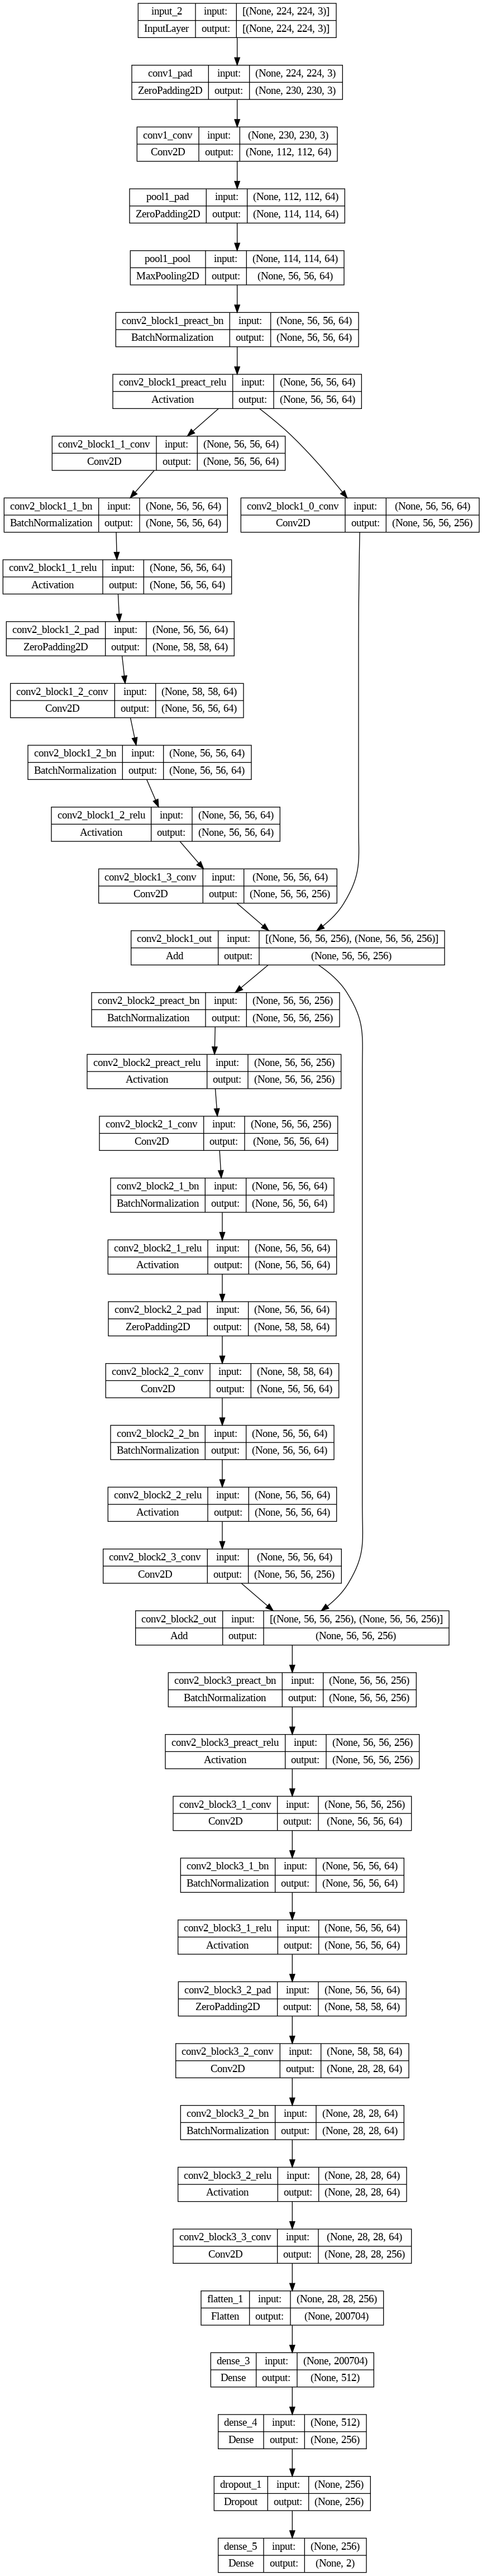

In [8]:
plot_model(peach_model, show_shapes=True, show_layer_names=True, to_file='peach_model.png')

Strawberry model architecture

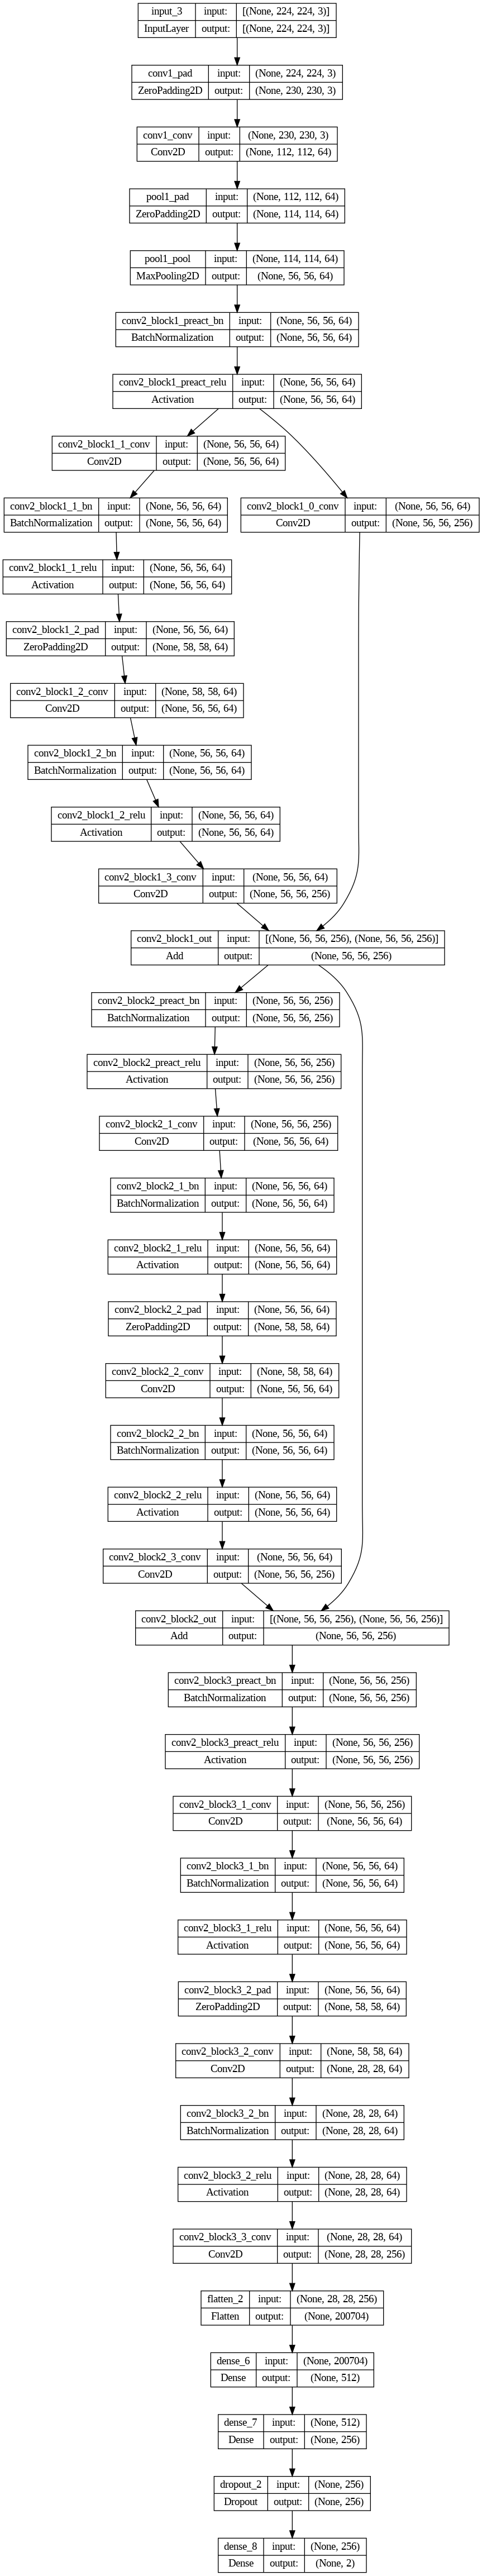

In [9]:
plot_model(strawberry_model, show_shapes=True, show_layer_names=True, to_file='strawberry_model.png')

# (Optional) Download the saved_model from google colab

Zip the saved model from google colab

In [ ]:
!zip -r /tmp/saved_model.zip /tmp/saved_model

  adding: tmp/saved_model/ (stored 0%)
  adding: tmp/saved_model/cherry/ (stored 0%)
  adding: tmp/saved_model/cherry/cherry_model.h5 (deflated 6%)
  adding: tmp/saved_model/strawberry/ (stored 0%)
  adding: tmp/saved_model/strawberry/strawberry_model.h5 (deflated 6%)
  adding: tmp/saved_model/peach/ (stored 0%)
  adding: tmp/saved_model/peach/peach_model.h5 (deflated 6%)


Download all saved model

In [ ]:
import shutil

# Source file path in the temporary directory
source_file_path = '/tmp/saved_model.zip'

# Destination file path in your Google Drive
destination_file_path = '/content/drive/MyDrive/saved_model_h5.zip'

# Copy the file from the temporary directory to your Google Drive
shutil.copyfile(source_file_path, destination_file_path)


'/content/drive/MyDrive/saved_model_h5.zip'

In [ ]:
# from google.colab import files

# !zip -r /tmp/saved_cherry.zip /tmp/saved_model/cherry
# files.download('/tmp/saved_cherry.zip')

In [ ]:
# !zip -r /tmp/saved_peach.zip /tmp/saved_model/peach
# files.download('/tmp/saved_peach.zip')

In [ ]:
# !zip -r /tmp/saved_strawberry.zip /tmp/saved_model/strawberry
# files.download('/tmp/strawberry.zip')